# Защита персональных данных клиентов

Проект по защите данных клиентов страховой компании "Хоть потоп" позволит обеспечить надежный механизм преобразования данных таким образом, чтобы по ним было сложно восстановить персональную информацию о пользователях. В ходе нашей работы мы исследуем имеющиеся входные данные и проанализируем главную проблему - изменяется ли качество модели машинного обучения (линейной регресии) при преобразовании исходных данных. 

Изучаемые данные можно представить следующей структурой: <br> 
**Признаки**: пол, возраст и зарплата застрахованного, количество членов его семьи. <br>
**Целевой признак**: количество страховых выплат клиенту за последние 5 лет.

Целью нашего проекта будет - подбор алгоритма преобразования, который не ухудшает качество модели машинного обучения. 

In [36]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. Предобработка данных 

Первоначально изучим имеющиеся данные. Проверим пропуски, дубликаты, типы переменных, возмножные аномальные значения, распределения величин, возможные корреляции.

In [37]:
#Считывание данных 
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('insurance.csv')  

In [38]:
#Вывод основной информации о данных 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [39]:
#Вывод начала таблицы
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


**Вывод**: из представленного видно, что тип данных соответсвующий столбцам "Возраст" и "Зарплата" может быть оптимизирован на тип int, представляющий целочисленные переменные. 

In [40]:
#Оптимизируем отмеченные переменные 
data['Зарплата'] = data['Зарплата'].astype('int64')
data['Возраст'] = data['Возраст'].astype('int64')

In [41]:
#Проверим изменение типов переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                5000 non-null   int64
 1   Возраст            5000 non-null   int64
 2   Зарплата           5000 non-null   int64
 3   Члены семьи        5000 non-null   int64
 4   Страховые выплаты  5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


**Вывод**: переменные соответствующие столбцам "Возраст" и "Зарплата" оптимиизированы к типу int. 

In [42]:
#Проверим данные на наличие пропусков
data.isnull().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

**Вывод**: явные пропуски в данных отсутствуют. 

In [43]:
#Проверим данные на наличие дубликатов 
data.duplicated().sum()

153

**Вывод**: в данных присутствует 153 дублированных значения, что составляет около 3% от всех имеющихся данных. 

In [44]:
#Удалим выявленные дублированные значения 
data = data.drop_duplicates()
data.duplicated().sum()

0

Проанализируем распределения имеющихся величин.

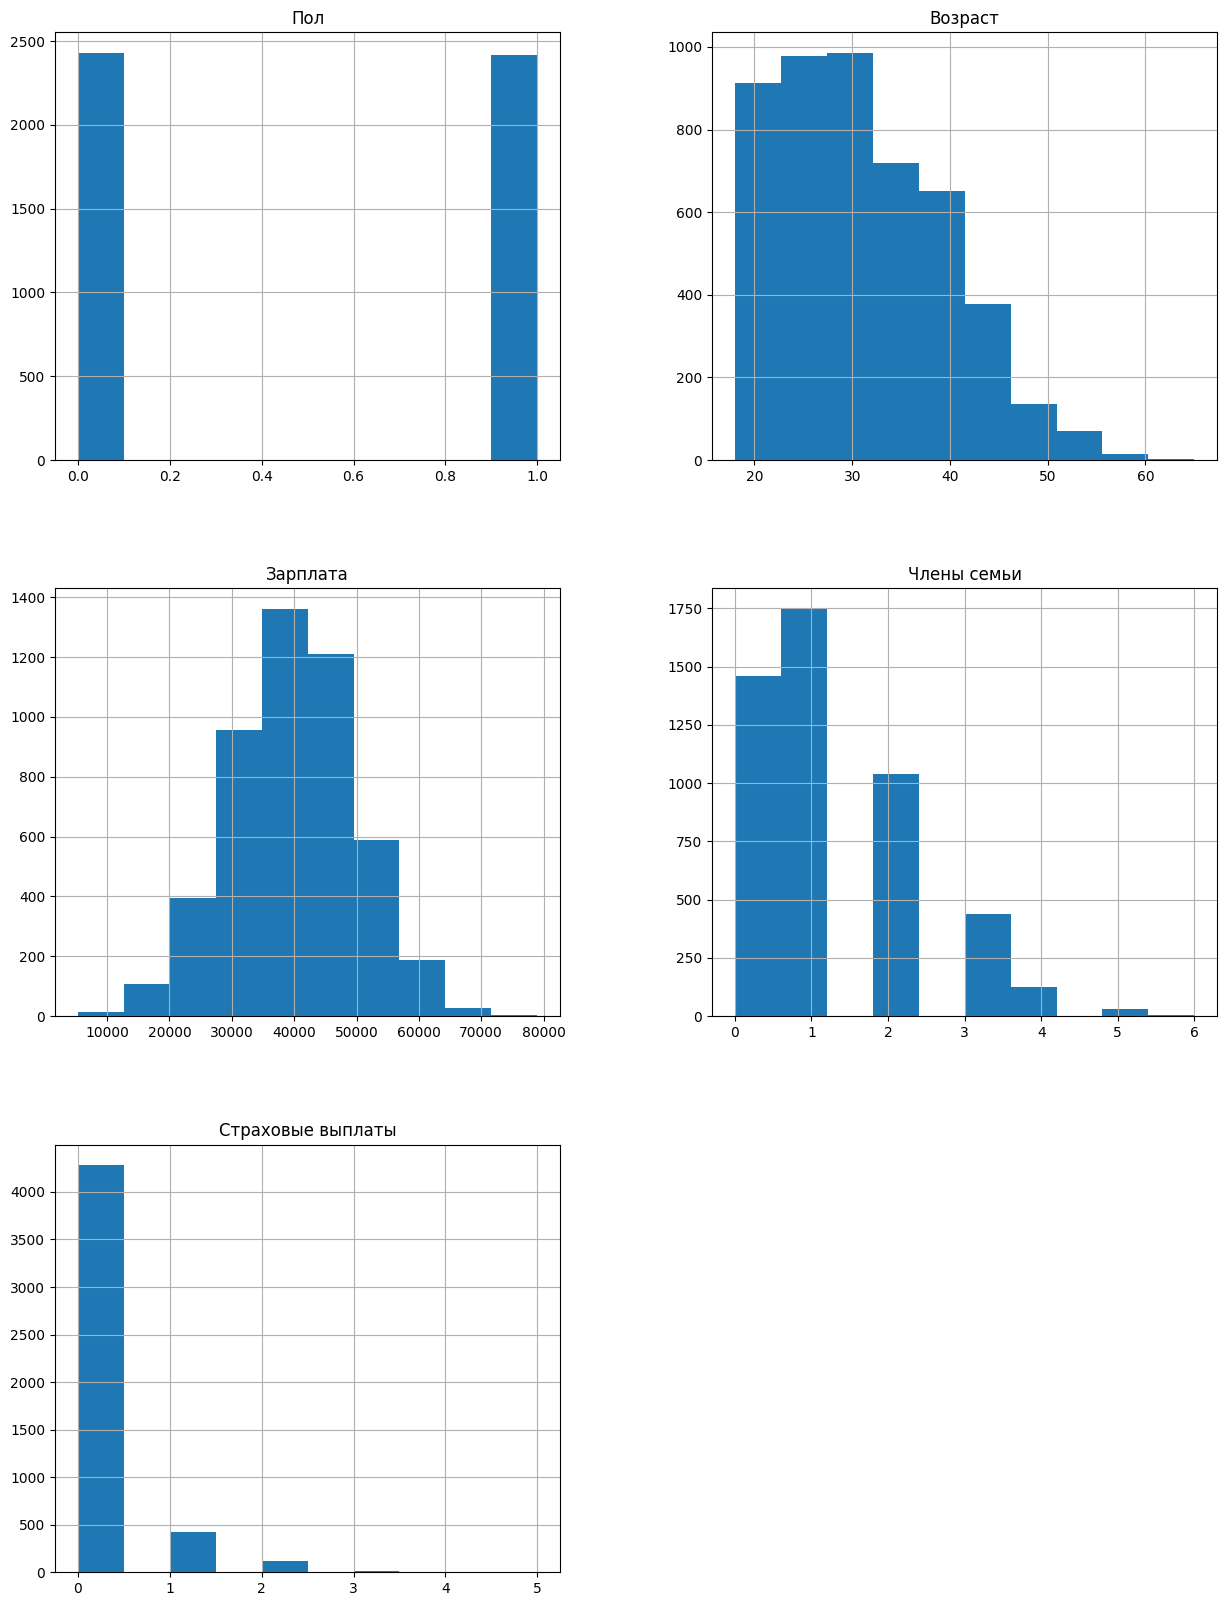

In [45]:
data.hist(figsize=(15,20));

In [46]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811223,1.203425,0.152259
std,0.500049,8.487995,9972.952441,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [47]:
data_features = data.drop('Страховые выплаты', axis = 1)
data_features.corr()


,Пол,Возраст,Зарплата,Члены семьи
Пол,1.000000,0.001953,0.015456,-0.007315
Возраст,0.001953,1.000000,-0.017386,-0.009064
Зарплата,0.015456,-0.017386,1.000000,-0.031687
Члены семьи,-0.007315,-0.009064,-0.031687,1.000000


**Вывод**: исходные данные были прочитаны и предваритально проанализированы. Выявлены дубликаты значений и неоптимизированные типы переменных. Явных аномалий и корреляций между переменными не обнаружено. 

# 2. Влияние умножения матриц на качество линейной регрессии

Исследуем гипотезу, что при домножении исходной матрицы признаков на любую обратимую матрицу качество применяемой линейной регрессии не изменится.  

Воспользуемся стандартными обозначениями: 

$X$ матрица признаков (нулевой столбец состоит из единиц)

$y$ вектор целевого признака

$w$ вектор весов линейной регрессии (нулевой элемент равен сдвигу)

$R$ вспомогательная матрица

Предсказания, даваемые с помощью линейной регрессии можно описать следующей формулой:
$a = Xw$

где $w$ вычисляется по следующей формуле $w$ = $(X^{T}X)^{-1}X^{T}y$

Если же мы домножим исходную матрицу на матрицу $R$ и применим к полученному такую формулу, то получим для вектора весов линейной регрессии
$w_1$ = $((XR)^{T}XR)^{-1}(XR)^{T}y$

Известно, что транспонированное произведение матриц равно произведению транспонированных матриц, взятых в обратном порядке. Тогда получаем: 

$w_1$ = $(R^{T}X^{T}XR)^{-1}R^{T}X^{T}y$

Известно также , что обратная матрица произведения матриц равна произведению обратных матриц, взятых в обратном порядке. Тогда последовательно применяя это свойство, получаем: 

$w_1$ = $(XR)^{-1}(R^{T}X^{T})^{-1}R^{T}X^{T}y$

$w_1$ = $(R)^{-1}X^{-1}(X^{T})^{-1}(R^{T})^{-1}R^{T}X^{T}y$

$(R^{T})^{-1}R^{T}$ - произведение обратных матриц, а значит равно $E$- единичной и не изменяет общее произведение

$w_1$ = $(R)^{-1}X^{-1}(X^{T})^{-1}X^{T}y$

Что можно представить в виде:

$w_1$ = $(R)^{-1}(X^{T}X)^{-1}X^{T}y$

Таким образом, исходная матрица весов и полученная связаны соотношением 
$w_1 = R^{-1}w$

Подставляя полученную матрицу весов линейной регрессии в исходную формулу для предсказаний 
$a = Xw_1 = XRR^{-1}w = Xw$

**Вывод**: Аналитическим путем была доказана гипотеза, что при домножении исходной матрицы признаков на обратимую матрицу, преобразование линейной регрессии остается прежним, а следовательно качество предсказаний также не изменяется. 

# 3. Преобразование исходных данных

Создадим алгоритм преобразования исходных данных, который затруднит их изначальную идентификацию. Очевидным примером такого преобразования будет домножение на матрицу случайных значений. 

In [48]:
#Создадим класс линейной регресии 
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [49]:
# Выделим столбец целевых признаков 
data_target = data['Страховые выплаты']

In [50]:
#создадим и обучим модель линейной регрессии на исходных данных, вычислим метрику R2
model = LinearRegression()
model.fit(data_features, data_target)
predictions = model.predict(data_features)
quality_1 = r2_score(data_target, predictions)
print(quality_1)

0.4302010046633359


In [51]:
#Сформируем исходную матрицу признаков, которые в дальнейшем будут использоваться для линейной регрессии
features_matrix = data_features.values
features_matrix.shape

(4847, 4)

In [52]:
features_matrix

array([[    1,    41, 49600,     1],
       [    0,    46, 38000,     1],
       [    0,    29, 21000,     0],
       ...,
       [    0,    20, 33900,     2],
       [    1,    22, 32700,     3],
       [    1,    28, 40600,     1]], dtype=int64)

Cформируем теперь произвольную матрицу, на которую и будем домножать нашу исходную.

In [53]:
extra_matrix = (100*(np.random.random((features_matrix.shape[1], features_matrix.shape[1])).round(2))).astype(int)
extra_matrix

array([[ 5, 77, 37, 28],
       [91, 89, 73, 70],
       [63, 71,  5, 41],
       [44, 88, 82, 78]])

In [54]:
#Проверим существование обратимой матрицы к созданной 
np.linalg.inv(extra_matrix)

array([[-0.00372454,  0.0194373 , -0.00104024, -0.01555993],
       [ 0.01965876,  0.00111224,  0.00388543, -0.0100975 ],
       [ 0.00886881,  0.02106213, -0.02481032, -0.00904426],
       [-0.02940172, -0.0343617 ,  0.02228588,  0.04249803]])

Произведем домножение исходной матрицы признаков на дополнительную матрицу.

In [55]:
features_matrix_2 = features_matrix @ extra_matrix
features_matrix_2.shape

(4847, 4)

In [56]:
data_features_2 = pd.DataFrame(features_matrix_2, columns = data_features.columns)

In [57]:
model_2 = LinearRegression()
model_2.fit(data_features_2, data_target)
predictions = model_2.predict(data_features_2)
quality_2 = r2_score(data_target, predictions)
print(quality_2)

0.4302010046626952


In [58]:
quality_1 - quality_2

6.407097075111778e-13

**Вывод**: создав необратимую матрицу, домножив ее на исходную матрицу признаков и сравнив показатель качества R2 для обеих матриц, мы приходим к выводу, что **значимого различия в качестве предсказаний нет**.

# 4. Проверка на адекватность

Сравним теперь качество предсказаний наших моделей и модели константной линейной регресии

In [59]:
class DummyLinearRegression:
    def fit(self, train_features, target_features):
        self.w = None
        self.w0 = None
    def predict(self, new_features):
        return np.zeros(new_features.shape[0])

In [60]:
model_3 = DummyLinearRegression()
model_3.fit(data_features, data_target)
predictions = model_3.predict(data_features)
quality_3 = r2_score(data_target, predictions)
print(quality_3)

-0.1054464928417953


**Вывод**: константная линейная регрессия выдает отрицательное значение метрики R2, что говорит о неэффективности ее предсказания.

# Вывод

В ходе работы были изучены исходные данные, проанализированы пропуски, дубликаты и аномальные значения. 
Был сформирован класс, который позволяет применять линейную регрессию и исследован вопрос об изменении качества предсказаний в зависимости от домножения исходной матрицы на вспомогательную. 
Таким образом в ходе исследования мы обнаружили, что домножение исходной матрицы признаков на любую обратимую матрицу не изменяет качество предсказания. 

Полученный результат позволяет осуществить шифрование исходных данных и обеспечить их сохранность. 